In [2]:
# Setting the environment variables
import os
import sys
import pandas as pd
import numpy as np
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct ,col, avg, mean, isnan, when, count, col, to_timestamp
from pyspark.sql.types import IntegerType

In [4]:
# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

spark

In [5]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [6]:
#Installing Matplotlib and Seaborn
!pip3 install matplotlib
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from datetime import timedelta

In [8]:
# loading the dataset from the EC2 instance - 2019-Oct.csv
df = spark.read.csv('/home/ec2-user/inputdata/2019-Oct.csv', header= True, inferSchema= False)

In [9]:
# exploring the dataframe - top 20 rows
df.show(20)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|  44600062|2103807459595387724|                null|shiseido|  35.79|541312140|72d76fde-8bb3-4e0...|
|2019-10-01 00:00:...|      view|   3900821|2053013552326770905|appliances.enviro...|    aqua|  33.20|554748717|9333dfbd-b87a-470...|
|2019-10-01 00:00:...|      view|  17200506|2053013559792632471|furniture.living_...|    null| 543.10|519107250|566511c2-e2e3-422...|
|2019-10-01 00:00:...|      view|   1307067|2053013558920217191|  computers.notebook|  lenovo| 251.74|550050854|7c90fc70-0e80-459...|
|2019-10-01 00:00:...|      view|   1004237|205301355563188265

In [10]:
# exploring the dataframe - schema
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)



In [11]:
# Number of columns in the dataset
len(df.columns)

9

In [12]:
#Number of rows in the dataset
df.count()

42448764

So, we have a huge dataset that contains 42 million rows.

Now, tha dataset is loaded in Spark environment. Let's proceed with the desired tasks.

In [13]:
#converting to parquet
df.write.parquet('parquet_df.parquet', mode='overwrite')

In [14]:
df_parq = spark.read.parquet('/home/ec2-user/parquet_df.parquet')

In [15]:
df_parq.show(5)

+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-10-11 05:40:...|      view|   1005135|2053013555631882655|electronics.smart...|  apple|1747.76|550180174|18776aab-5a2f-4e7...|
|2019-10-11 05:40:...|      view|   8500281|2053013552259662037|                null|  stark| 499.34|535408245|c16e7cd7-7c20-477...|
|2019-10-11 05:40:...|      view|   1004249|2053013555631882655|electronics.smart...|  apple| 746.17|531416893|faf3a9f4-4731-425...|
|2019-10-11 05:40:...|      cart|   1004873|2053013555631882655|electronics.smart...|samsung| 378.93|513877997|6ad6470e-6e89-440...|
|2019-10-11 05:40:...|      view|   1005102|2053013555631882655|elect

<hr>

## Task 1 - Data Exploration

**Find**
- 5 most popular:
    - Products sold by the e-commerce company in the month
    - Brands on the platform
    - Product categories
- Number of unique users and the most active user on the platform
- Average and maximum price for smartphones purchased by the customers
<br>

**Plot and comment**
- Event-type funnel distribution in e-commerce shopping journey
- Traffic on different days of the week

Provide the results in a separate report.

In [16]:
#changing price column to integer type
df_parq=df_parq.withColumn("price",df_parq["price"].cast(IntegerType()))

In [17]:
# 5 most popular products sold
df_parq.filter(df_parq.event_type == 'purchase').groupBy("product_id").count().orderBy("count", ascending = False).show(5)

+----------+-----+
|product_id|count|
+----------+-----+
|   1004856|28944|
|   1004767|21806|
|   1004833|12697|
|   1005115|12543|
|   4804056|12381|
+----------+-----+
only showing top 5 rows



In [18]:
# 5 most product categories sold
df_parq.groupBy('category_code').count().orderBy('count', ascending= False).show(5)

+--------------------+--------+
|       category_code|   count|
+--------------------+--------+
|                null|13515609|
|electronics.smart...|11507231|
|  electronics.clocks| 1311033|
|  computers.notebook| 1137623|
|electronics.video.tv| 1113750|
+--------------------+--------+
only showing top 5 rows



In [19]:
# 5 most popular brands
df_parq.groupBy('brand').count().orderBy('count', ascending= False).show(5)

+-------+-------+
|  brand|  count|
+-------+-------+
|   null|6113008|
|samsung|5282775|
|  apple|4122554|
| xiaomi|3083763|
| huawei|1111205|
+-------+-------+
only showing top 5 rows



In [20]:
# Number of unique users
df_parq.select(countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                3022290|
+-----------------------+



In [21]:
# The most active user on the platform
df_parq.groupBy('user_id').count().orderBy('count', ascending= False).show(1)

+---------+-----+
|  user_id|count|
+---------+-----+
|512475445| 7436|
+---------+-----+
only showing top 1 row



In [22]:
# Maximum price for smartphones purchased by the customers
df_smartphone = df_parq[(df_parq['category_code'] == 'electronics.smartphone')]
df_smartphone.agg({'price':'max'}).collect()

[Row(max(price)=2110)]

In [23]:
# Average price for smartphones purchased by the customers
df_smartphone.agg({'price':'avg'}).collect()

[Row(avg(price)=471.4504376422095)]

In [24]:
#from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import to_timestamp, dayofweek, hour

In [25]:
df_parq = df_parq.withColumn("Date_time", to_timestamp('event_time', 'yyyy-MM-dd HH:mm:ss'))

In [26]:
# Event-type funnel distribution
# Remember Spark dataframe cannot be visualised directly
event_df = df.groupBy('event_type').count().toPandas()
print(event_df)

  event_type     count
0   purchase    742849
1       view  40779399
2       cart    926516


In [27]:
df_parq.select("Date_time").dtypes

[('Date_time', 'timestamp')]

In [28]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly
df_event_type_df= df_parq.groupBy('event_type').count().toPandas()

Text(0.5, 0, 'Event type')

<Figure size 1008x720 with 0 Axes>

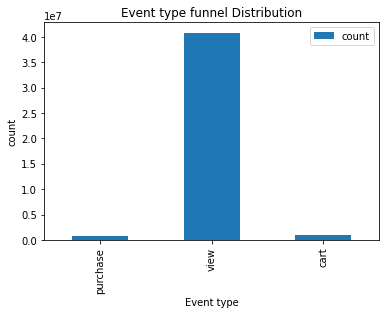

In [29]:
plt.figure(figsize=(14,10))
df_event_type_df.plot(x= 'event_type', y ='count' , kind= 'bar')
plt.title('Event type funnel Distribution')
plt.ylabel('count')
plt.xlabel('Event type')

In [30]:
# Traffic on different days of the week
# Remember Spark dataframe cannot be visualised directly
df_parq=df_parq.withColumn('day_of_week', dayofweek(df_parq.Date_time))

df_parq.groupBy('day_of_week').count().show()

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|          1|5855995|
|          6|5829660|
|          3|6801885|
|          5|6380367|
|          4|6652532|
|          7|5606796|
|          2|5321529|
+-----------+-------+



In [31]:
day_of_week_df= df_parq.groupBy('day_of_week').count().toPandas()

Text(0.5, 0, 'Day of week')

<Figure size 1008x720 with 0 Axes>

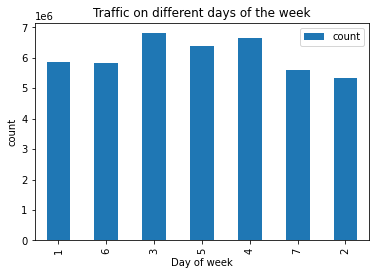

In [32]:
plt.figure(figsize=(14,10))
day_of_week_df.plot(x= 'day_of_week', y ='count' , kind= 'bar')
plt.title('Traffic on different days of the week')
plt.ylabel('count')
plt.xlabel('Day of week')

In [33]:
# drop redundant column(s), if any
df_parq= df_parq.drop('event_time')

In [34]:
df_parq.show(5)

+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+-------------------+-----------+
|event_type|product_id|        category_id|       category_code|  brand|price|  user_id|        user_session|          Date_time|day_of_week|
+----------+----------+-------------------+--------------------+-------+-----+---------+--------------------+-------------------+-----------+
|      view|   1005135|2053013555631882655|electronics.smart...|  apple| 1747|550180174|18776aab-5a2f-4e7...|2019-10-11 05:40:25|          6|
|      view|   8500281|2053013552259662037|                null|  stark|  499|535408245|c16e7cd7-7c20-477...|2019-10-11 05:40:25|          6|
|      view|   1004249|2053013555631882655|electronics.smart...|  apple|  746|531416893|faf3a9f4-4731-425...|2019-10-11 05:40:25|          6|
|      cart|   1004873|2053013555631882655|electronics.smart...|samsung|  378|513877997|6ad6470e-6e89-440...|2019-10-11 05:40:25|          6|
|     

<hr>

## Task 2 - Feature Engineering

- Handle missing values (provide justification for approach)
- Generate the category code at 2 levels (Split into 2 columns)
    - Example: electronics.video.tv - electronics, video
- Capture user activity in different columns
    - Total activities (view/cart/etc.) in the session
    - Affinity towards a particular product (Product count for user)
    - Affinity towards a category (Secondary category count for user)
    - Average shopping expense for a product category (secondary)
    - Number of user sessions
- Impact of time: Day and Hour (Binning hours into 4 buckets)
- Reduction in brands for analysis: Top 20 + ‘others’
- Target variable generation: is_purchased


In [35]:
# Handling missing values 
from pyspark.sql.functions import when, count, col, isnull
df_parq.select([count(when(isnull(c), c)).alias(c) for c in df_parq.columns]).show()

+----------+----------+-----------+-------------+-------+-----+-------+------------+---------+-----------+
|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|Date_time|day_of_week|
+----------+----------+-----------+-------------+-------+-----+-------+------------+---------+-----------+
|         0|         0|          0|     13515609|6113008|    0|      0|           2|        0|          0|
+----------+----------+-----------+-------------+-------+-----+-------+------------+---------+-----------+



In [36]:
#removing null values from category code
df_parq=df_parq[(df_parq['category_code'] != 'null')]

In [37]:
#removing none values from brand
df_parq=df_parq[(df_parq['brand'] != 'None')]

In [38]:
#dropping the rows with null values
df_parq = df_parq.na.drop()

Reason for the action performed:



In [39]:
#dropping duplicate entries
df_parq = df_parq.dropDuplicates(df_parq.columns)

In [40]:
df_parq.dtypes

[('event_type', 'string'),
 ('product_id', 'string'),
 ('category_id', 'string'),
 ('category_code', 'string'),
 ('brand', 'string'),
 ('price', 'int'),
 ('user_id', 'string'),
 ('user_session', 'string'),
 ('Date_time', 'timestamp'),
 ('day_of_week', 'int')]

In [41]:
# Generating 2 columns from category code
# Columns have only single entity (electronics.video.tv: electronics, video)
# Check if split command works with '.' or Spark treats it as special character
from pyspark.sql.functions import split


In [42]:
df_parq= df_parq.withColumn("category1", split(col("category_code"),"\.").getItem(0)) \
.withColumn("category2", split(col("category_code"),"\.").getItem(1)) \
.drop('category_code')

In [43]:
# Check if the column is added
df_parq.columns

['event_type',
 'product_id',
 'category_id',
 'brand',
 'price',
 'user_id',
 'user_session',
 'Date_time',
 'day_of_week',
 'category1',
 'category2']

In [44]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import udf, lit
from pyspark.sql.functions import collect_list, collect_set
from pyspark.sql import functions as func

In [45]:
# Activities in a session by the user
# Window functions can be helpful here

df_parq =df_parq.withColumn('activity_indicator', lit(1))

windowval1 = Window.partitionBy('user_id', 'user_session')

df_parq = df_parq.withColumn('activity_countval', func.sum('activity_indicator').over(windowval1))

df_parq = df_parq.drop('activity_indicator')

interesting_columns = ['user_id', 'product_id', 'price', 'activity_countval']

In [46]:
# View count for a product by the user
# Window functions can be helpful here

from pyspark.sql.types import FloatType, IntegerType

product_view_indicators = udf(lambda c: 1 if c == 'view' else 0, IntegerType())

df_parq =df_parq.withColumn('product_view_indication', product_view_indicators('event_type'))

windowval1= Window.partitionBy('user_id', 'product_id')

df_parq = df_parq.withColumn('product_view_counts', func.sum('product_view_indication').over(windowval1))

df_parq = df_parq.drop('product_view_indication')

interesting_columns += ['product_view_counts']

In [47]:
# View count for the secondary category by the user
# Window functions can be helpful here

from pyspark.sql.types import FloatType, IntegerType

category2_view_indicators = udf(lambda c: 1 if c == 'view' else 0, IntegerType())

df_parq =df_parq.withColumn('category2_indication', category2_view_indicators('event_type'))

windowval1= Window.partitionBy('user_id', 'category2')

df_parq = df_parq.withColumn('category2_view_counts', func.sum('category2_indication').over(windowval1))

df_parq = df_parq.drop('category2_indication')

interesting_columns += ['category2_view_counts']

In [48]:
# Average shopping expense for a product category
# Window functions can be helpful here

purchase_indicator = udf(lambda c: 1 if c== 'purchase' else 0, IntegerType())

df_parq=df_parq.withColumn('purchase_indications', purchase_indicator('event_type'))

df_parq=df_parq.withColumn('purchase_price', df_parq.purchase_indications*df_parq.price)

Windowval1= Window.partitionBy('user_id', 'category2')

df_parq=df_parq.withColumn('total_shopping_expense', func.sum('purchase_price').over(windowval1))

df_parq=df_parq.withColumn('total_purchase_count', func.sum('purchase_indications').over(windowval1))

df_parq=df_parq.withColumn('average_shopping_expense', df_parq.total_shopping_expense / df_parq.total_purchase_count)

df_parq.drop('total_shopping_expense','purchase_price')

interesting_columns += ['average_shopping_expense']

In [49]:
# Session count for a user
# Window functions can be helpful here

df_parq=df_parq.withColumn('session_indications', lit(1))

windowval1 = Window.partitionBy('user_id')

df_parq=df_parq.withColumn('session_counts', func.sum('session_indications').over(windowval1))

df_parq = df_parq.drop('session_indications')

interesting_columns += ['session_counts']

In [50]:
# Generating the hour variable
from pyspark.sql.functions import to_timestamp, dayofweek, hour

from pyspark.sql.functions import col, avg

df_parq = df_parq.withColumn("hour", hour(col("Date_Time")))

In [51]:
from pyspark.ml.feature import Bucketizer

splits = [0, 6, 12, 18, 24]

bucketizer = Bucketizer(splits=splits, inputCol="hour", outputCol="binnedhour")

df_parq = bucketizer.transform(df_parq)

print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))

Bucketizer output with 4 buckets


In [52]:
# Reduction in brands for analysis: Top 20 + ‘others'
top_20_brands = df_parq.groupBy("brand").count().orderBy("count", ascending = False).select('brand').toPandas()

In [53]:
top_20_brands =list(top_20_brands.brand[:20])
top_20_brands

['samsung',
 'apple',
 'xiaomi',
 'huawei',
 'lg',
 'oppo',
 'acer',
 'lenovo',
 'bosch',
 'hp',
 'indesit',
 'respect',
 'casio',
 'artel',
 'sony',
 'elenberg',
 'asus',
 'beko',
 'haier',
 'pioneer']

In [54]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import udf

brand_indicators = udf(lambda c:c if c in top_20_brands else 'others')

df_parq = df_parq.withColumn('brand_new', brand_indicators('brand'))

df_parq = df_parq.drop('brand')
interesting_columns += ['brand_new']

In [55]:
# Generating 'is_purchased' variable
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType
import pyspark.sql.functions as f

df_parq = df_parq.withColumn('is_purchased', f.when(df_parq['event_type']=='purchase',1).otherwise(0))

w = Window.partitionBy("user_id","product_id")

df_parq = df_parq.withColumn("label", f.max("is_purchased").over(w))

interesting_columns += ['label']

In [56]:
# Generating 'is_purchased' variable
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, IntegerType
import pyspark.sql.functions as f

df_parq = df_parq.withColumn('is_purchased', f.when(df_parq['event_type']=='purchase',1).otherwise(0))

w = Window.partitionBy("user_id","product_id")

df_parq = df_parq.withColumn("label", f.max("is_purchased").over(w))

interesting_columns += ['label']

In [57]:
df_parq.columns

['event_type',
 'product_id',
 'category_id',
 'price',
 'user_id',
 'user_session',
 'Date_time',
 'day_of_week',
 'category1',
 'category2',
 'activity_countval',
 'product_view_counts',
 'category2_view_counts',
 'purchase_indications',
 'purchase_price',
 'total_shopping_expense',
 'total_purchase_count',
 'average_shopping_expense',
 'session_counts',
 'hour',
 'binnedhour',
 'brand_new',
 'is_purchased',
 'label']

In [58]:
# Dropping redundant columns
df_parq=df_parq.drop('user_session', 'Date_time', 'category_id', 'purchase_price',
 'total_shopping_expense', 'hour', 'user_id', 'product_id', 'purchase_indications', 'total_purchase_count')

In [59]:
df_parq.columns

['event_type',
 'price',
 'day_of_week',
 'category1',
 'category2',
 'activity_countval',
 'product_view_counts',
 'category2_view_counts',
 'average_shopping_expense',
 'session_counts',
 'binnedhour',
 'brand_new',
 'is_purchased',
 'label']

In [60]:
# Printing the top 20 rows as output
df_parq.show(20)

+----------+-----+-----------+------------+-----------+-----------------+-------------------+---------------------+------------------------+--------------+----------+---------+------------+-----+
|event_type|price|day_of_week|   category1|  category2|activity_countval|product_view_counts|category2_view_counts|average_shopping_expense|session_counts|binnedhour|brand_new|is_purchased|label|
+----------+-----+-----------+------------+-----------+-----------------+-------------------+---------------------+------------------------+--------------+----------+---------+------------+-----+
|      view|  111|          6|   furniture|living_room|                4|                  2|                    4|                    null|             4|       2.0|   others|           0|    0|
|      view|  111|          6|   furniture|living_room|                4|                  2|                    4|                    null|             4|       2.0|   others|           0|    0|
|      view|  275|  

In [61]:
os.environ['HADOOP_HOME'] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
sys.path.append("/home/ec2-user/spark-2.4.4-bin-hadoop2.7/bin")

In [62]:
# Columns in df after feature engineering
df_parq =df_parq.dropDuplicates(df_parq.columns)

In [63]:
# Storing the cleaned df in the instance to prevent repetition of steps again
# Rename the file based on your preferences
df_parq.coalesce(1).write.format("csv").mode("overwrite").save("df_updated2")

Proceed to another notebooks after saving the dataframe.